In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
import itertools    

In [2]:
from keras.utils.vis_utils import plot_model

In [3]:
from tensorflow.keras import  layers, models
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Input,GlobalAveragePooling2D
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from keras.applications.inception_v3 import InceptionV3

In [6]:
data_dir = Path('/kaggle/input/knee-osteoarthritis-dataset-with-severity')

train_dir = data_dir / 'train'
train_dir

PosixPath('/kaggle/input/knee-osteoarthritis-dataset-with-severity/train')

In [7]:
healthy_cases_dir = train_dir / '0'
doubtful_cases_dir = train_dir / '1'
minimal_cases_dir = train_dir / '2'
moderate_cases_dir = train_dir / '3'
severe_cases_dir = train_dir / '4'

# Get the list of all the images
healthy_cases = healthy_cases_dir.glob('*.png')
doubtful_cases = doubtful_cases_dir.glob('*.png')
minimal_cases = minimal_cases_dir.glob('*.png')
moderate_cases = moderate_cases_dir.glob('*.png')
severe_cases = severe_cases_dir.glob('*.png')

In [8]:
train_data = []
for img in healthy_cases:
  train_data.append((img, 0))
for img in doubtful_cases:
  train_data.append((img,1))
for img in minimal_cases:
  train_data.append((img,2))
for img in moderate_cases:
  train_data.append((img, 3))
for img in severe_cases:
  train_data.append((img, 4))
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

In [9]:
train_data.head()

,image,label
0,/kaggle/input/knee-osteoarthritis-dataset-with...,3
1,/kaggle/input/knee-osteoarthritis-dataset-with...,0
2,/kaggle/input/knee-osteoarthritis-dataset-with...,0
3,/kaggle/input/knee-osteoarthritis-dataset-with...,0
4,/kaggle/input/knee-osteoarthritis-dataset-with...,2


In [10]:
train_data.shape

(5778, 2)

0    2286
2    1516
1    1046
3     757
4     173
Name: label, dtype: int64


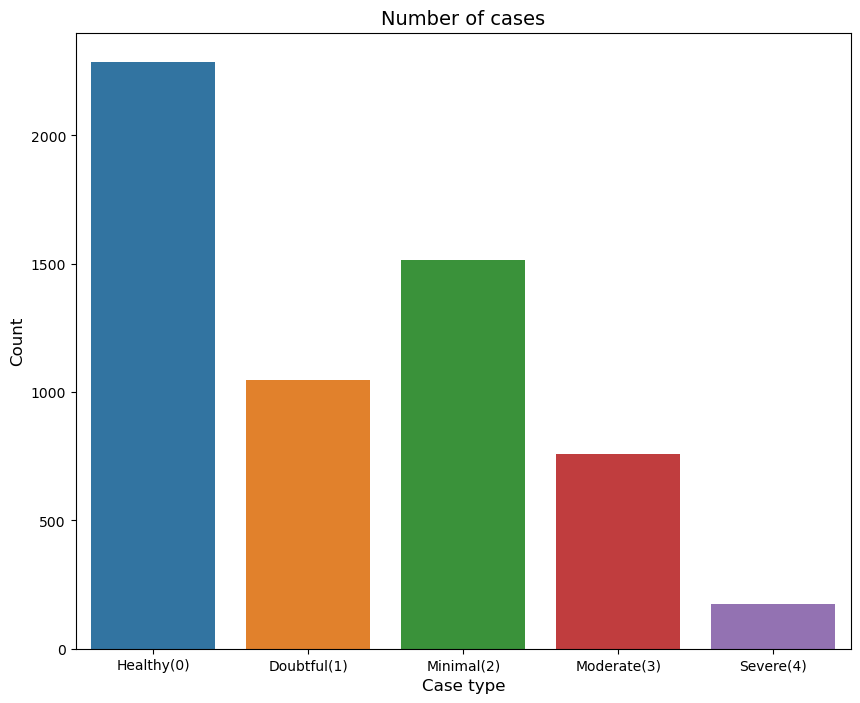

In [8]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Healthy(0)','Doubtful(1)', 'Minimal(2)', 'Moderate(3)','Severe(4)'])
plt.show()

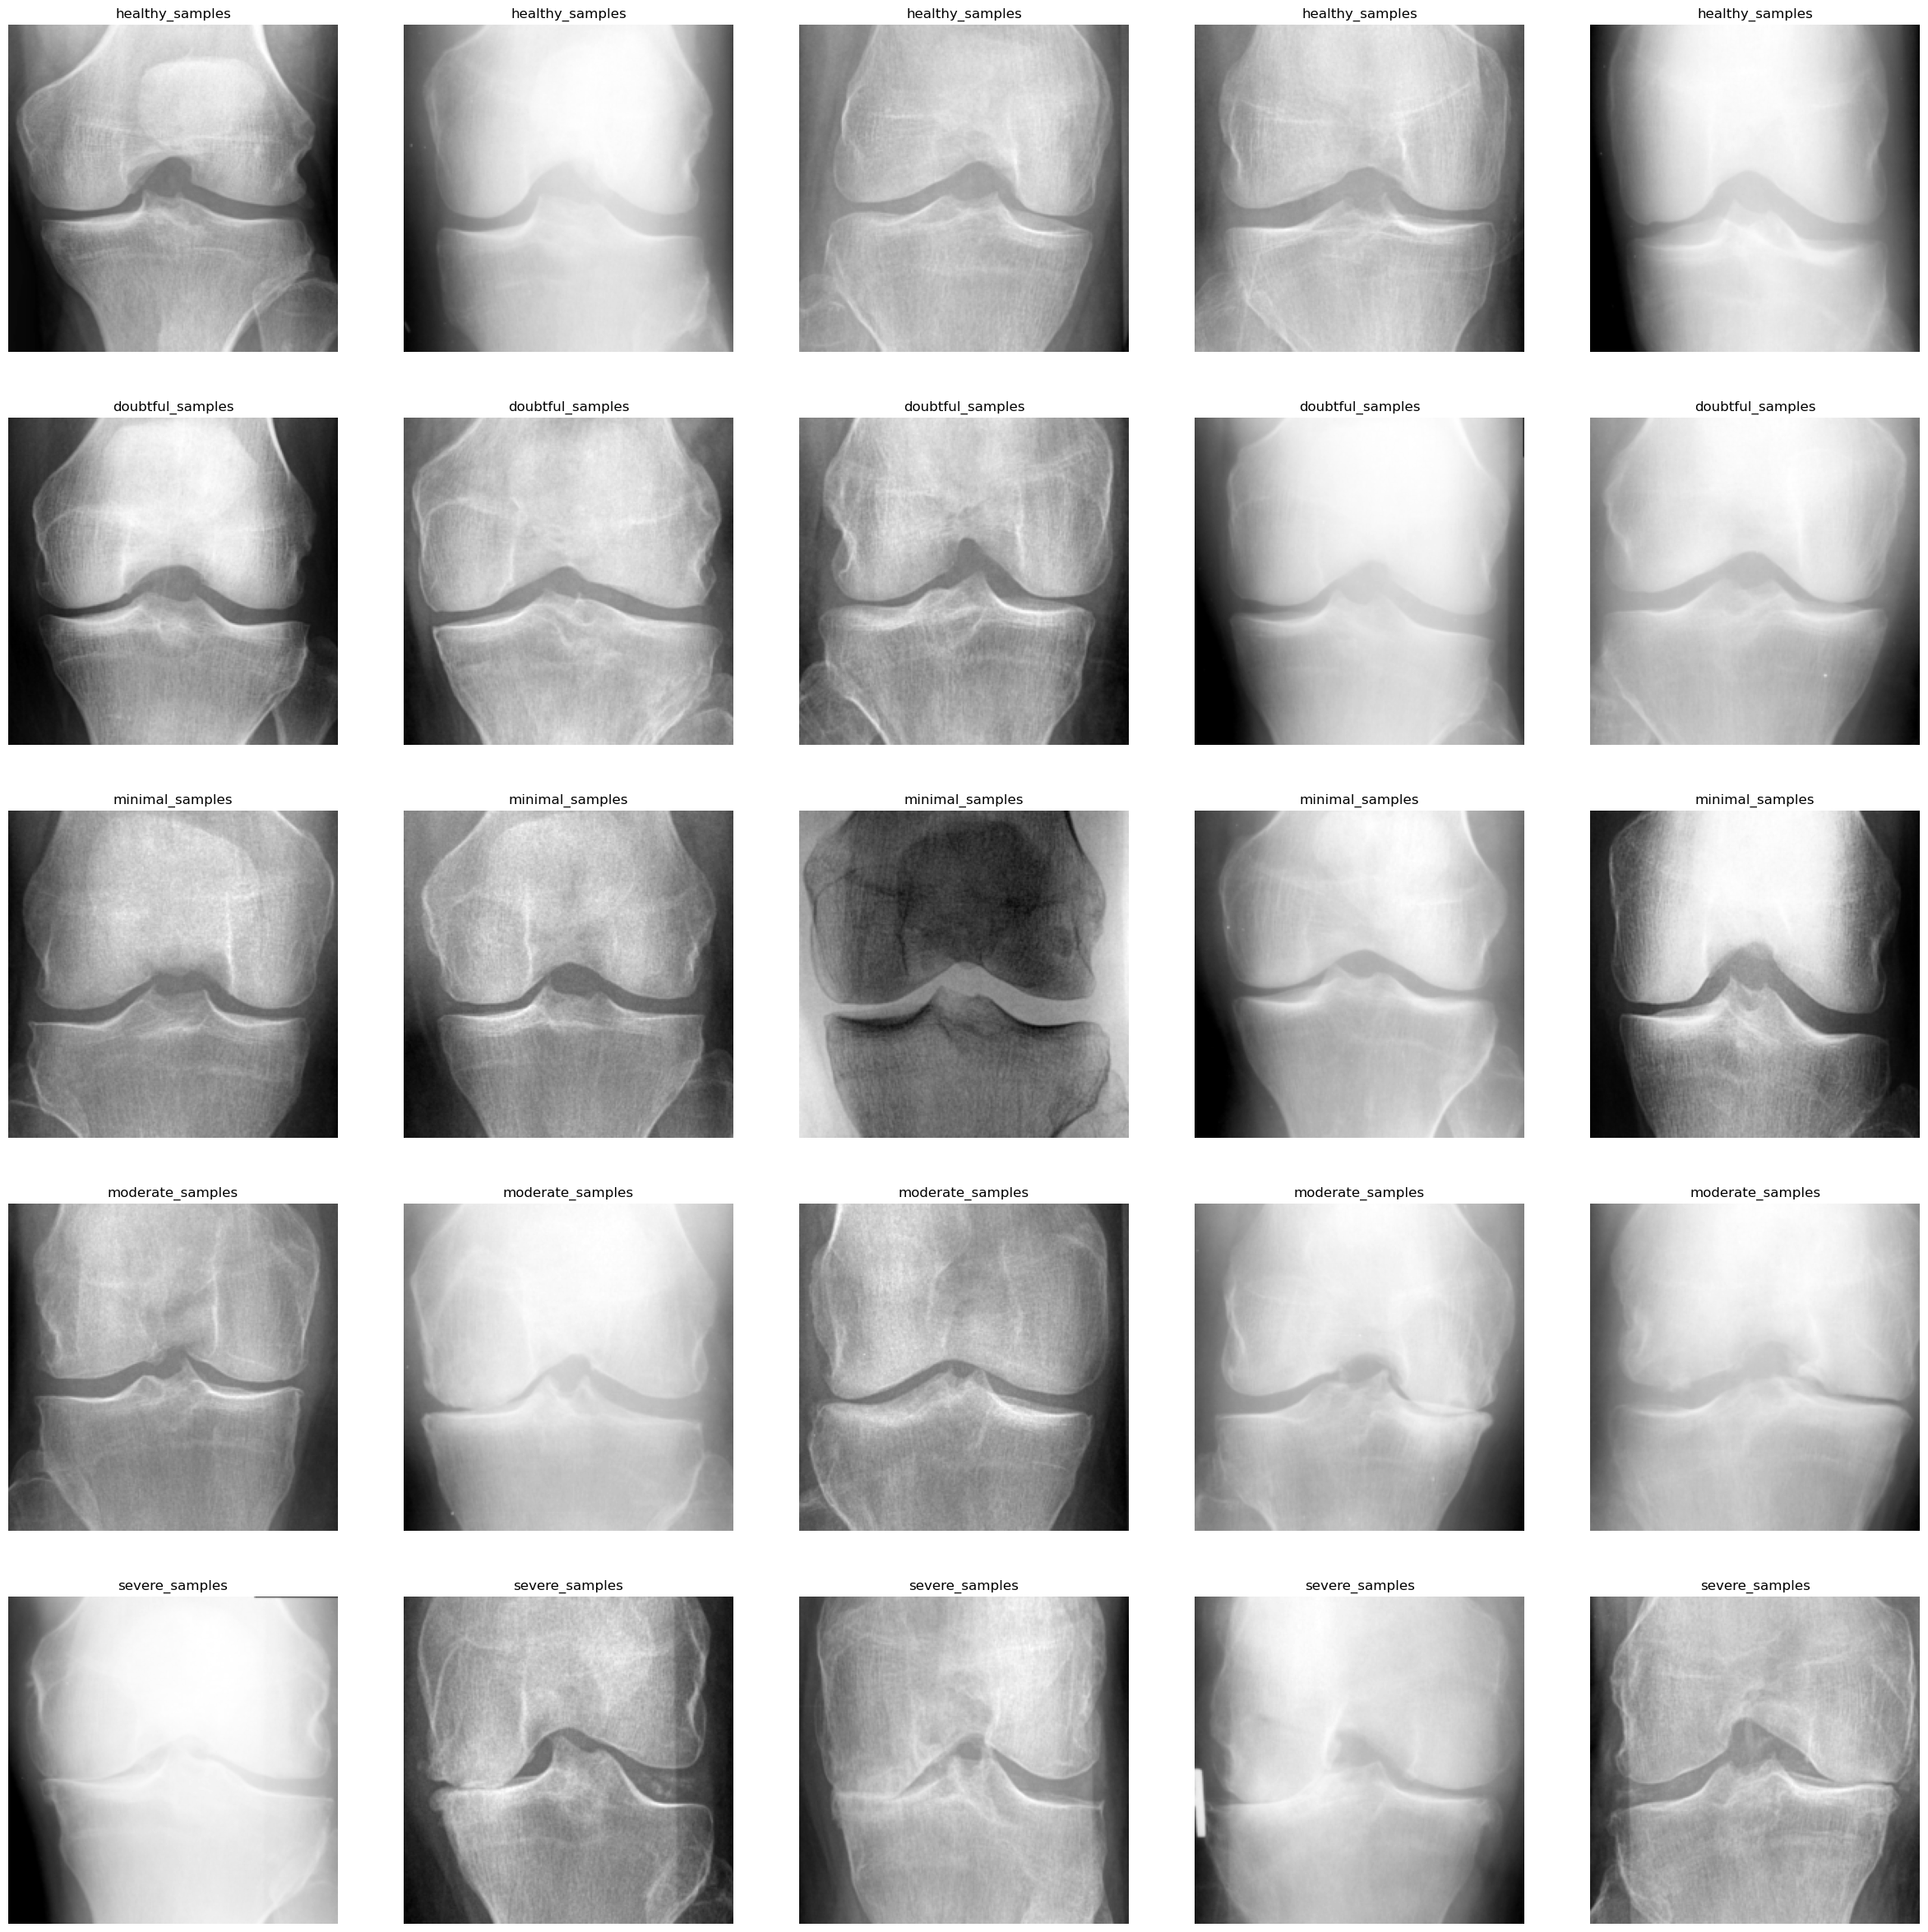

In [9]:
healthy_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
doubtful_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
minimal_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
moderate_samples = (train_data[train_data['label']==3]['image'].iloc[:5]).tolist()
severe_samples = (train_data[train_data['label']==4]['image'].iloc[:5]).tolist()
    
# Concat the data in a single list and del the above two list
samples = healthy_samples + doubtful_samples+minimal_samples+moderate_samples+severe_samples
del healthy_samples, doubtful_samples,minimal_samples,moderate_samples,severe_samples

# Plot the data 
f, ax = plt.subplots(5,5, figsize=(30,30))
for i in range(25):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("healthy_samples")
    elif i<10:
        ax[i//5, i%5].set_title("doubtful_samples")
    elif i<15:
        ax[i//5, i%5].set_title("minimal_samples")
    elif i<20:
        ax[i//5, i%5].set_title("moderate_samples")
    elif i<25:
        ax[i//5, i%5].set_title("severe_samples")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [9]:
# Check if the image is in grayscale mode
def check_image_mode(image):
  if image.mode == 'L':
      print('The image is in grayscale mode')
  else:
      print('The image is in RGB mode')

In [10]:
from PIL import Image as pil_image

# Open the image file
image = pil_image.open(train_data[train_data['label']==0]['image'].iloc[0])
check_image_mode(image)
image = pil_image.open(train_data[train_data['label']==1]['image'].iloc[0])
check_image_mode(image)
image = pil_image.open(train_data[train_data['label']==2]['image'].iloc[0])
check_image_mode(image)
image = pil_image.open(train_data[train_data['label']==3]['image'].iloc[0])
check_image_mode(image)
image = pil_image.open(train_data[train_data['label']==4]['image'].iloc[0])
check_image_mode(image)

The image is in grayscale mode
The image is in grayscale mode
The image is in grayscale mode
The image is in grayscale mode
The image is in grayscale mode


In [11]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
healthy_cases_dir = train_dir / '0'
doubtful_cases_dir = train_dir / '1'
minimal_cases_dir = train_dir / '2'
moderate_cases_dir = train_dir / '3'
severe_cases_dir = train_dir / '4'

# Get the list of all the images
healthy_cases = healthy_cases_dir.glob('*.png')
doubtful_cases = doubtful_cases_dir.glob('*.png')
minimal_cases = minimal_cases_dir.glob('*.png')
moderate_cases = moderate_cases_dir.glob('*.png')
severe_cases = severe_cases_dir.glob('*.png')

train_data = []
train_labels = []

for img in healthy_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    img=np.array(img)
    img = img/255
    label = 'Healthy'
    train_data.append(img)
    train_labels.append(label)


for img in doubtful_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    img=np.array(img)
    img = img/255
    label ='Doubtful'
    train_data.append(img)
    train_labels.append(label)


for img in minimal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    img=np.array(img)
    img = img/255
    label = 'Minimal'
    train_data.append(img)
    train_labels.append(label)
    
for img in moderate_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    img=np.array(img)
    img = img/255
    label = 'Moderate'
    train_data.append(img)
    train_labels.append(label)   

for img in severe_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    img=np.array(img)
    img = img/255
    label = 'Severe'
    train_data.append(img)
    train_labels.append(label) 

train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)

Total number of validation examples:  (5778, 64, 64, 3)
Total number of labels: (5778,)


In [12]:
train_data1.shape

(5778, 64, 64, 3)

In [12]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1.head()

,label
0,Healthy
1,Healthy
2,Healthy
3,Healthy
4,Healthy


In [14]:
train_labels1['label'].unique()

array(['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe'],
      dtype=object)

In [13]:
train_labels1['label']=train_labels1['label'].map({'Healthy':0,'Doubtful':1,'Minimal':2,'Moderate':3,"Severe":4})

In [14]:
train_labels1.isnull().sum()

label    0
dtype: int64

In [15]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
train_rows=len(train_data1)
train_data1 = train_data1.reshape(train_rows,-1)
train_data2, train_labels2 = smt.fit_resample(train_data1, train_labels1)

0    2286
1    2286
2    2286
3    2286
4    2286
Name: label, dtype: int64


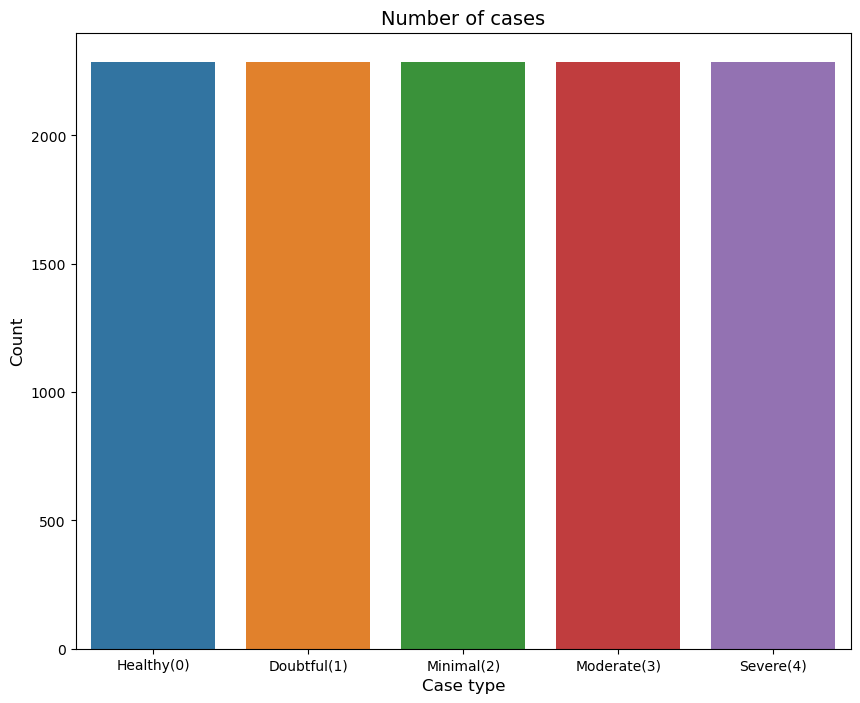

In [19]:
cases_count1 = train_labels2['label'].value_counts()
print(cases_count1)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count1.index, y= cases_count1.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Healthy(0)','Doubtful(1)', 'Minimal(2)', 'Moderate(3)','Severe(4)'])
plt.show()

In [18]:
train_data2.shape

(11430, 12288)

In [19]:
train_labels2.shape

(11430, 1)

In [20]:
train_labels2['label'].value_counts()

0    2286
1    2286
2    2286
3    2286
4    2286
Name: label, dtype: int64

In [16]:
train_data2 =train_data2.reshape(-1,64,64,3)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data2, train_labels2, test_size=0.23, random_state=42)

In [23]:
X_train.shape

(8801, 64, 64, 3)

In [18]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)
  
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    if savefig:
        fig.savefig("confusion_matrix.png")

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [7]:
def get_model():
    
    base_model = ResNet152V2(input_shape=(64,64,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model

In [ ]:
model = get_model()


  2498560/234545216 [..............................] - ETA: 7:58

In [35]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics='accuracy')
history=model.fit(np.array(X_train), np.array(y_train), batch_size=80, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
111/111 [==============================] - 58s 230ms/step - loss: 1.4317 - accuracy: 0.3673 - val_loss: 1.9106 - val_accuracy: 0.2043
Epoch 2/50
111/111 [==============================] - 21s 186ms/step - loss: 1.0497 - accuracy: 0.5357 - val_loss: 1.2198 - val_accuracy: 0.4618
Epoch 3/50
111/111 [==============================] - 21s 188ms/step - loss: 0.8166 - accuracy: 0.6463 - val_loss: 1.0576 - val_accuracy: 0.5181
Epoch 4/50
111/111 [==============================] - 22s 196ms/step - loss: 0.6550 - accuracy: 0.7253 - val_loss: 0.7938 - val_accuracy: 0.6542
Epoch 5/50
111/111 [==============================] - 21s 191ms/step - loss: 0.5003 - accuracy: 0.7955 - val_loss: 0.7771 - val_accuracy: 0.6816
Epoch 6/50
111/111 [==============================] - 22s 199ms/step - loss: 0.3846 - accuracy: 0.8464 - val_loss: 0.8424 - val_accuracy: 0.6908
Epoch 7/50
111/111 [==============================] - 21s 193ms/step - loss: 0.2774 - accuracy: 0.8950 - val_loss: 1.0679 - val_ac

In [36]:
pred = model.predict(X_test)

83/83 [==============================] - 7s 36ms/step


In [37]:
pred = np.argmax(pred,axis=1)

In [38]:
pred

array([2, 4, 4, ..., 4, 3, 4])

In [39]:
labels={0:'Healthy',1:'Doubtful',2:'Minimal',3:'Moderate',4:'Severe'}

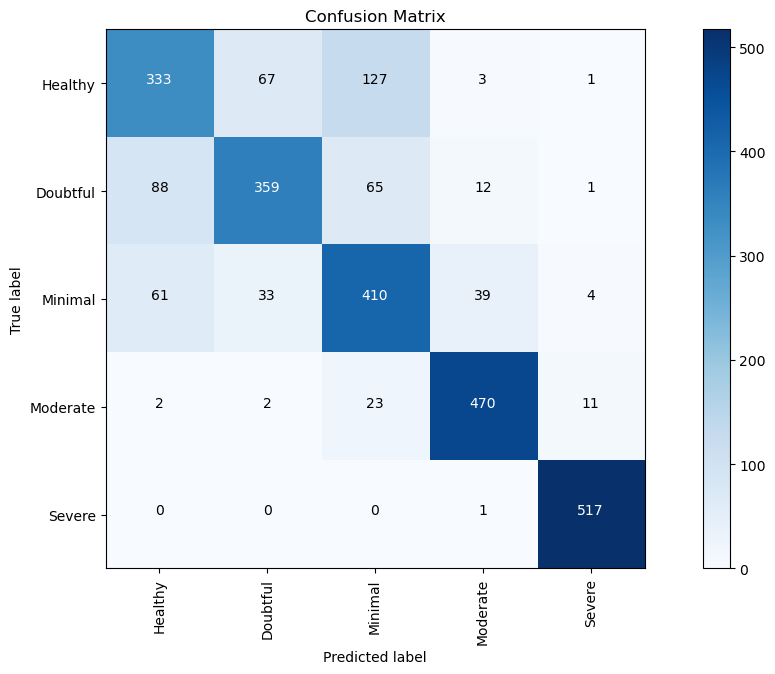

In [40]:
make_confusion_matrix(y_test, pred, list(labels.values()))

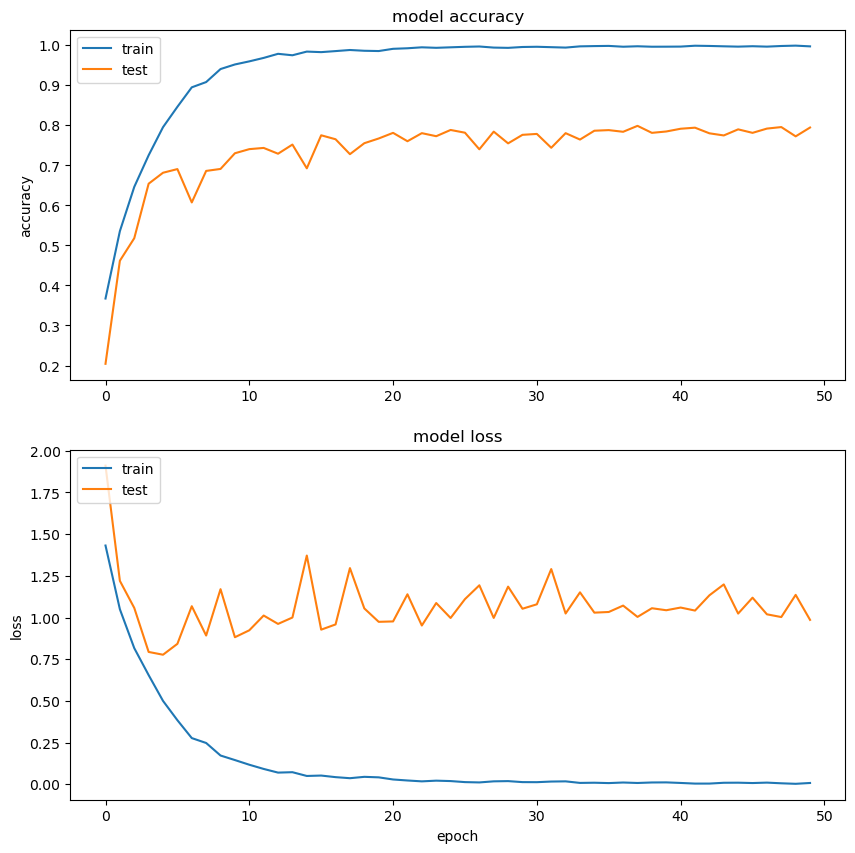

In [41]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:

print("Model precision score on test is: ", round(precision_score(y_test, pred, average='micro'),3))
print('-'*50)
print("Model recall score on test is: ", round(recall_score(y_test, pred, average='micro'),3))
print('-'*50)
print("Model F1 score on test is: ", round(f1_score(y_test, pred, average='micro'),3))
print('-'*50)

Model precision score on test is:  0.795
--------------------------------------------------
Model recall score on test is:  0.795
--------------------------------------------------
Model F1 score on test is:  0.795
--------------------------------------------------


# CNN

In [20]:
input_shape = (64,64, 3)
model = Sequential([
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2))])
model.add(layers.Flatten())
model.add(layers.Dense(640, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(264, activation='relu'))
model.add(layers.Dense(128, activation='softmax'))

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [21]:
history=model.fit(np.array(X_train), np.array(y_train), epochs=70, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/70
276/276 [==============================] - 14s 13ms/step - loss: 1.7014 - accuracy: 0.1992 - val_loss: 1.6222 - val_accuracy: 0.2020
Epoch 2/70
276/276 [==============================] - 3s 12ms/step - loss: 1.6279 - accuracy: 0.2038 - val_loss: 1.6126 - val_accuracy: 0.2012
Epoch 3/70
276/276 [==============================] - 3s 12ms/step - loss: 1.6177 - accuracy: 0.2128 - val_loss: 1.6246 - val_accuracy: 0.2020
Epoch 4/70
276/276 [==============================] - 3s 12ms/step - loss: 1.6165 - accuracy: 0.2057 - val_loss: 1.6072 - val_accuracy: 0.2050
Epoch 5/70
276/276 [==============================] - 3s 10ms/step - loss: 1.6116 - accuracy: 0.2136 - val_loss: 1.6104 - val_accuracy: 0.2020
Epoch 6/70
276/276 [==============================] - 2s 9ms/step - loss: 1.6062 - accuracy: 0.2170 - val_loss: 1.5945 - val_accuracy: 0.2324
Epoch 7/70
276/276 [==============================] - 3s 10ms/step - loss: 1.4866 - accuracy: 0.3099 - val_loss: 1.4051 - val_accuracy: 0.3872

In [26]:
pred = model.predict(X_test)

83/83 [==============================] - 0s 3ms/step


In [27]:
pred = np.argmax(pred,axis=1)

In [29]:
labels={0:'Healthy',1:'Doubtful',2:'Minimal',3:'Moderate',4:'Severe'}

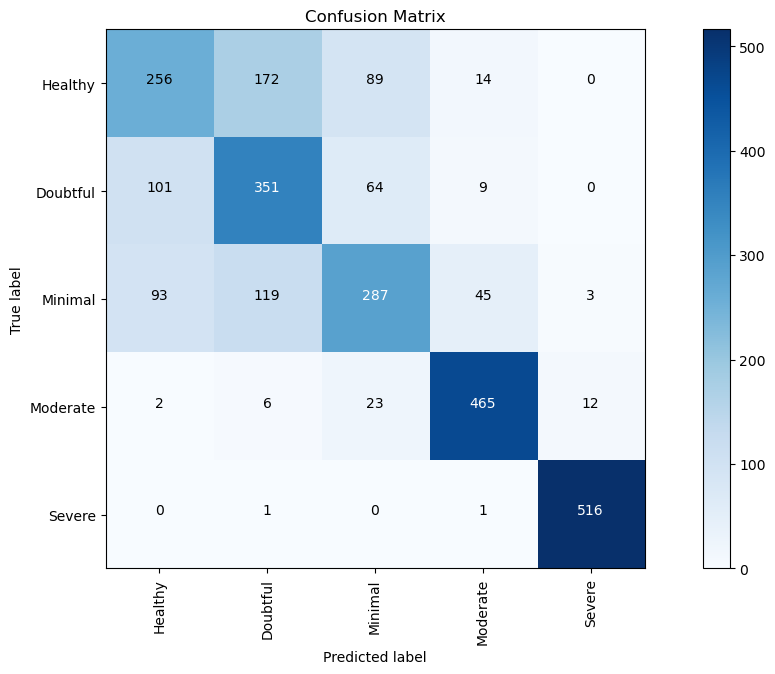

In [30]:
make_confusion_matrix(y_test, pred, list(labels.values()))

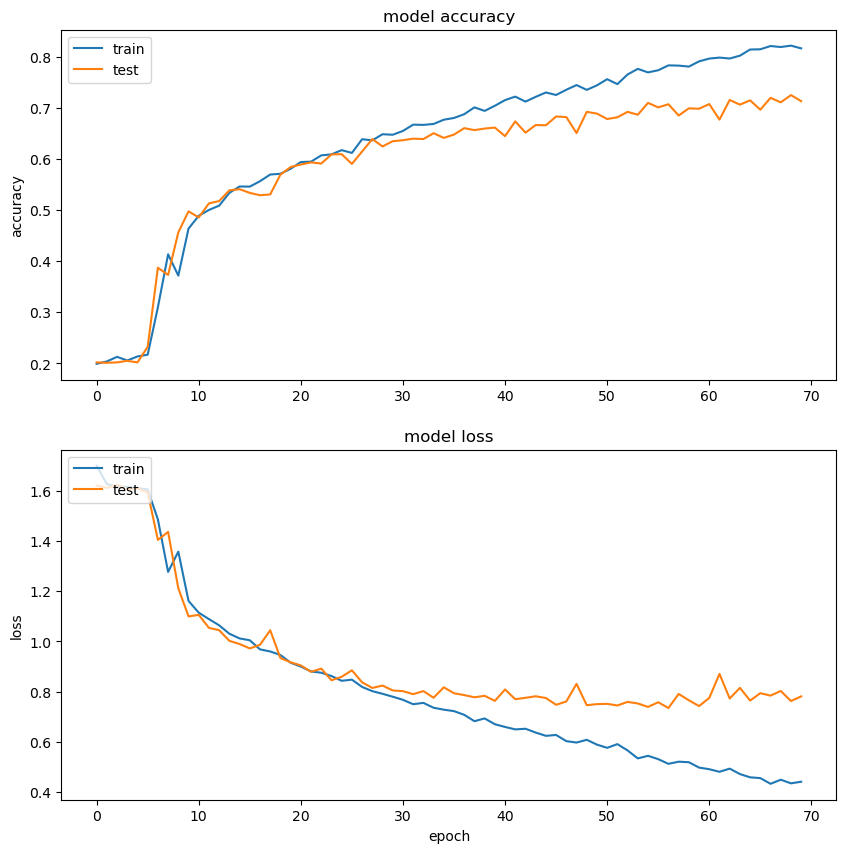

In [31]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:

print("Model precision score on test is: ", round(precision_score(y_test, pred, average='micro'),3))
print('-'*50)
print("Model recall score on test is: ", round(recall_score(y_test, pred, average='micro'),3))
print('-'*50)
print("Model F1 score on test is: ", round(f1_score(y_test, pred, average='micro'),3))
print('-'*50)

Model precision score on test is:  0.713
--------------------------------------------------
Model recall score on test is:  0.713
--------------------------------------------------
Model F1 score on test is:  0.713
--------------------------------------------------
